In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model


2025-04-12 11:21:23.674615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# --- Step 1: Load image paths and labels ---
base_dir = 'CancerSkin'
categories = ['Normal', 'Cancer']

image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_paths.append(os.path.join(category_path, filename))
            labels.append(category)

# --- Step 2: Train-test split and label encoding ---
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


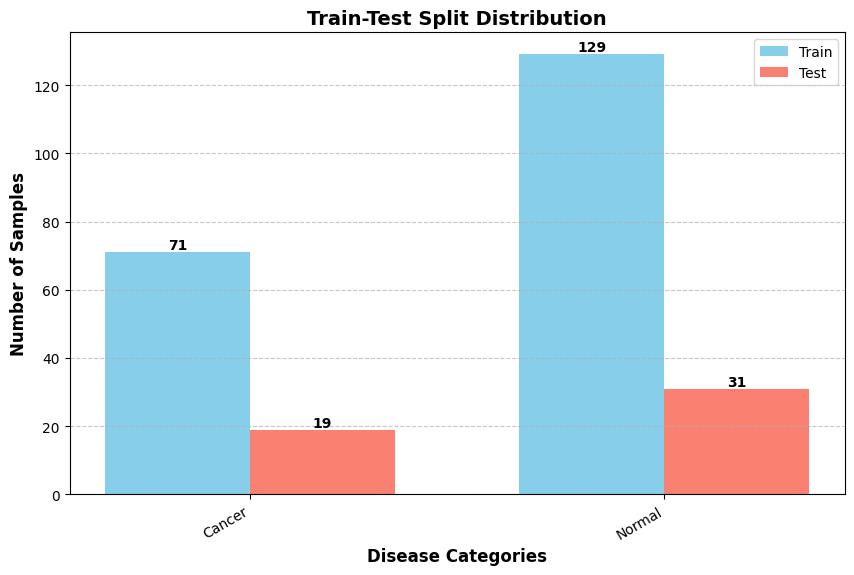

In [3]:

# Define categories (class labels)

categories = list(label_encoder.classes_)

# Count occurrences of each class
train_counts = [np.count_nonzero(y_train == i) for i in range(len(categories))]
test_counts = [np.count_nonzero(y_test == i) for i in range(len(categories))]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(categories))

# Create bars
train_bars = plt.bar(index, train_counts, bar_width, label='Train', color='skyblue')
test_bars = plt.bar(index + bar_width, test_counts, bar_width, label='Test', color='salmon')

# Add numbers on top of bars
for bars in [train_bars, test_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Formatting the plot
plt.xlabel('Disease Categories', fontsize=12, fontweight='bold')  # ✅ Label for x-axis
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Train-Test Split Distribution', fontsize=14, fontweight='bold')
plt.xticks(index + bar_width / 2, categories, rotation=30, ha="right", fontsize=10)  # ✅ Class names added
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better readability

plt.show()


**Thực hiện phân loại ảnh**

In [4]:

# Step 1: Hàm đọc và resize ảnh + chuẩn hóa theo chuẩn ResNet50
def load_images_resnet(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)
        img = preprocess_input(img)  # Dùng hàm chuẩn hóa từ ResNet
        images.append(img)
    return np.array(images)

# Step 2: Create train-test split  
X_train, X_test, y_train, y_test = train_test_split(  
    image_paths,  
    labels,  
    test_size=0.2,  # 20% of data will be used as test set  
    random_state=42,  # For reproducibility 
) 

# Step 3:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Encoding train labels
y_test = label_encoder.transform(y_test)  # Encoding test labels

# Step 4: Convert to categorical (one-hot encoding)
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Step 5: Áp dụng cho train/test
x_train = load_images_resnet(X_train)
x_test = load_images_resnet(X_test)

# --- Step 6: Build ResNet50 model ---
# Load ResNet50 pre-trained, không bao gồm lớp output gốc
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Không cho học lại trọng số gốc

# Thêm các lớp phía trên (custom head)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Giảm overfitting
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Gộp thành model hoàn chỉnh
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- Step 7: Train the model ---
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# --- Step 8: Evaluate the model ---
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\n🎯 Test Accuracy ResNet50: {test_acc:.4f}")

# Step 9: Vẽ biểu đồ training/validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy ResNet50')
plt.legend()
plt.grid()
plt.show()


2025-04-12 11:31:56.662084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1124)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


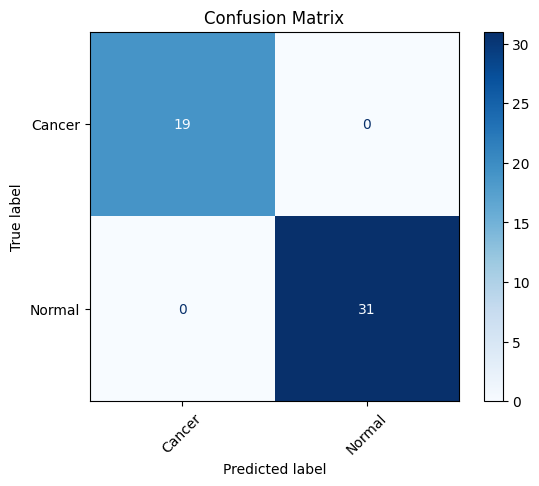

              precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00        19
      Normal       1.00      1.00      1.00        31

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [5]:
# Step 1: Predict on the test set
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Step 2: Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Báo cáo phân loại
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))
